<a href="https://colab.research.google.com/github/TurboGooseEdu/machine-learning/blob/task-3/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

Выполнил: Коновалов Илья, группа 23.М07-мм

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# EDA

## Исходный датасет

* `age` : возраст в годах
* `sex` : пол (1 = мужской; 0 = женский)
* `cp` : тип боли в груди
* `trestbps` : артериальное давление в состоянии покоя (в мм рт. ст. при поступлении в стационар)
* `chol` : холестерин сыворотки в мг/дл
* `fbs` : уровень сахара в крови натощак > 120 мг/дл (1 = верно; 0 = неверно)
* `restecg` : результаты электрокардиографии в покое
* `thalach` : достигнутая максимальная частота сердечных сокращений
* `exang` : стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
* `oldpeak` : Депрессия сегмента ST, вызванная физическими упражнениями, по сравнению с отдыхом
* `slope` : наклон пикового сегмента ST при нагрузке
* `ca` : количество магистральных сосудов (0-3), окрашенных флюороскопией
* `thal` : 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект

Целевой признак - `target` : имеет ли человек заболевания сердца (1 = да; 0 = нет)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ml/datasets/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
df.describe(include="all")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


## Соотношение больных и здоровых

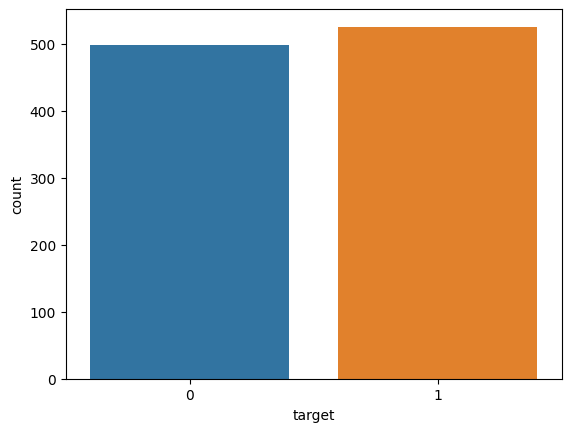

In [5]:
sns.countplot(x="target", data=df);

## Соотношение мужчин и женщин

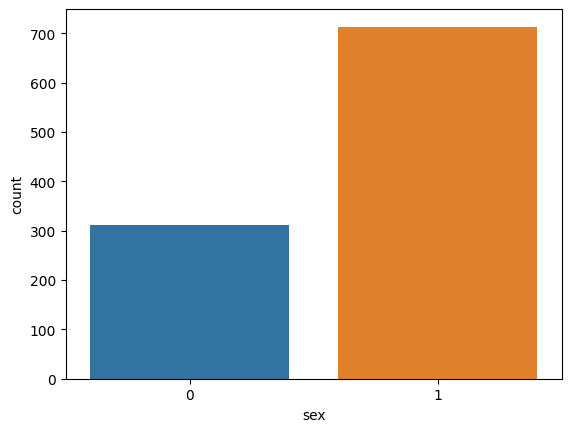

In [6]:
sns.countplot(x="sex", data=df);

## Соотношение больных и здоровых в зависимости от пола

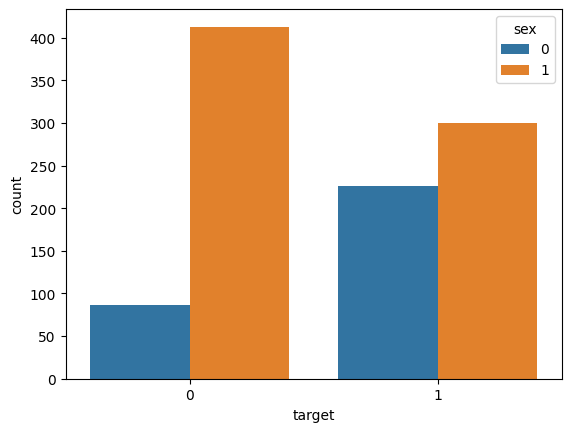

In [7]:
sns.countplot(x="target", hue="sex", data=df);

## Распределение больных и здоровых по возрастам

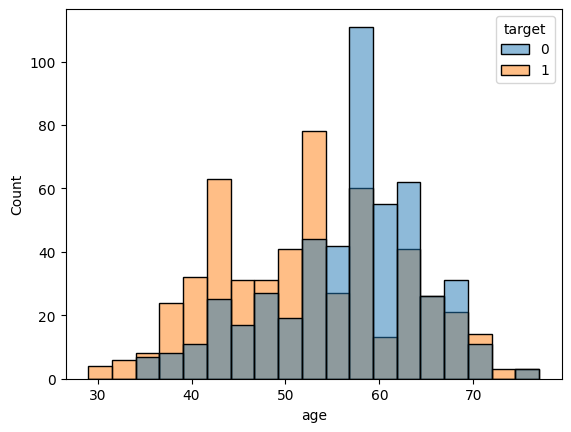

In [8]:
sns.histplot(df, x="age", hue="target");

## Показатели холестерина больных и здоровых людей в зависимости от возраста

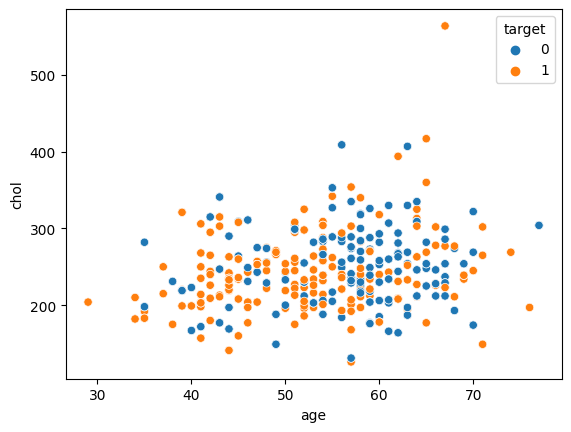

In [9]:
sns.scatterplot(x="age", y="chol", hue="target", data=df);

## Количество больных и здоровых в зависимости от типа грудной боли

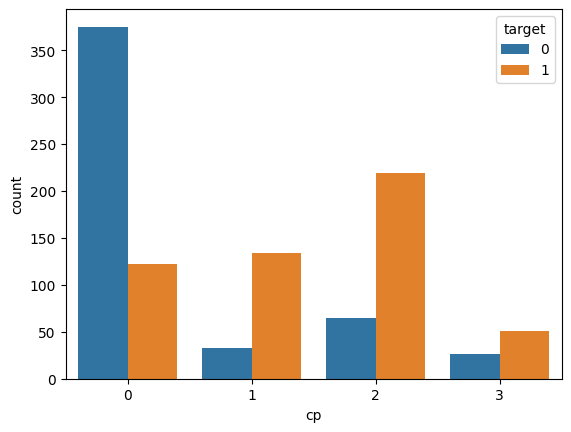

In [10]:
sns.countplot(x="cp", hue="target", data=df);

## Корреляция признаков

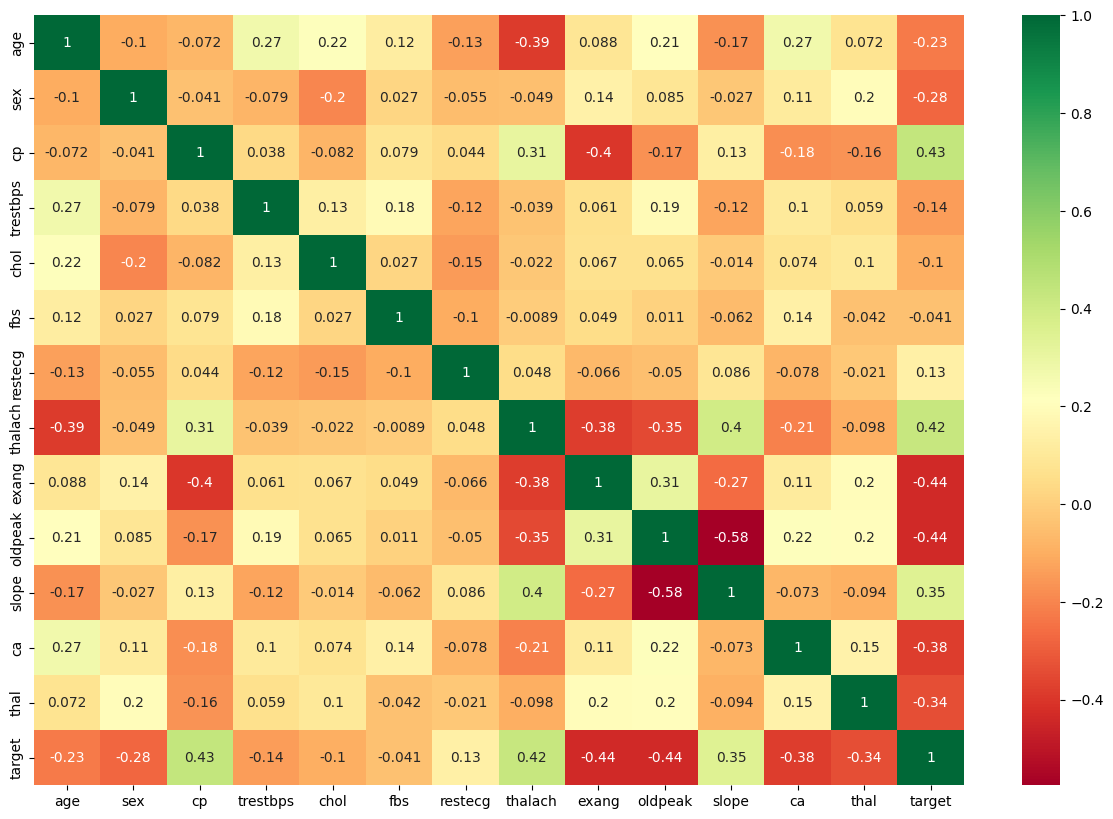

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', ax=ax)
plt.show()

## Выводы по датасету
- Примерно поровну больных и здоровых
- Мужчин в 2 раза больше, чем женщин
- Более половины мужчин здоровы, в то время как большинство женщин больны
- До 55 больше больных людей, после 55 - больше здоровых
- Уровни холестерина у больных и здоровых людей примерно одинаковы
- Среди людей без боли в груди (тип боли = 0), подавляющее большинство здоровы. В то же время для остальных типов боли подавляющее большинство - больны
- Значительных корреляций между признаками не наблюдается

# Подготовка данных

#### Масштабирование

In [12]:
y = df['target']
x_full = df.drop(['target'], axis=1)

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_full), columns=x_full.columns)

#### Подбор наилучших признаков

In [13]:
rfecv = RFECV(estimator=LogisticRegression())
rfecv.fit(x, y)

best_cols = list(x.columns[rfecv.support_])
print("Достаточное число признаков:", rfecv.n_features_)
print("Наиболее значимые признаки:", *best_cols)

x = x[best_cols]

Достаточное число признаков: 12
Наиболее значимые признаки: age sex cp trestbps chol restecg thalach exang oldpeak slope ca thal


#### Разбиение на тренировочные и проверочные данные

In [14]:
x_np = x.to_numpy()
y_np = y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Реализация собственных методов обучения

## SVM

In [15]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lmda = lmda


    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self._classes = unique_labels(y)
        self.X_ = X
        self.y_ = y
        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            if y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1:
                dw = 2 * self.lmda * self.w
                db = 0
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_label[index])
                db = y_label[index]
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Decision Tree

In [16]:
def _mse(x):
    y_pred = np.mean(x)
    return np.mean(np.square(x - y_pred))


def _mean_accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)


def gini(y):
    classes = np.unique(y)
    prob = []
    for cl in classes:
        prob.append(len(y[y == cl]) / len(y))

    s = 0
    for p in prob:
        s += p * p
    return 1 - s


def entropy(y):
    classes = np.unique(y)
    prob = []
    for cl in classes:
        prob.append(len(y[y == cl]) / len(y))

    s = 0
    for p in prob:
        s += p * np.log2(p)
    return -s


class Node:
    def __init__(self, left=None, right=None, condition=None, value=None):
        self.child = (left, right) if left is not None else None
        self.feature = condition[0] if condition is not None else None
        self.threshold = condition[1] if condition is not None else None
        self.value = value

    def predict(self, x: pd.DataFrame):
        if self.value is not None:
            if isinstance(self.value, pd.DataFrame):
                print("Value is dataframe")
            return self.value

        left = x[x[self.feature] <= self.threshold]
        right = x[~(x[self.feature] <= self.threshold)]

        left_value = self.child[0].predict(left)
        right_value = self.child[1].predict(right)

        try:
            left_value = left_value["prediction"] if isinstance(left_value, pd.DataFrame) and not left_value.empty else left_value
        except:
            print(left_value)
        try:
            right_value = right_value["prediction"] if isinstance(right_value, pd.DataFrame) and not right_value.empty else right_value
        except:
            print(right_value)

        if len(x[x[self.feature] <= self.threshold].index) > 0:
            x.loc[x[self.feature] <= self.threshold, "prediction"] = left_value
        if len(x[~(x[self.feature] <= self.threshold)].index) > 0:
            x.loc[~(x[self.feature] <= self.threshold), "prediction"] = right_value
        return x


class DecisionTree:
    def __init__(self, num_classes, ig_threshold, max_depth, split_method="all",
            choose_method="all", criterion="entropy", probability=0):
        self.max_depth = max_depth
        self.min_ig = ig_threshold
        self.split_method = split_method
        self.choose_method = self.information_grow_all if choose_method == "all" else self.information_grow_random
        self.max_iter = 500
        self.loss_func = entropy
        self.probability = probability
        self.classes = list(range(num_classes))

    def fit(self, x: pd.DataFrame, y: np.ndarray | pd.DataFrame):
        if isinstance(y, pd.DataFrame):
            y = y.to_numpy()
        x["target"] = y
        self.root = self._tree_build(x)

    def _calculate_ig(self, mse, left: pd.DataFrame, right: pd.DataFrame, n):
        left_entropy = self.loss_func(left["target"].to_numpy())
        right_entropy = self.loss_func(right["target"].to_numpy())

        ig = mse - (
                (len(left.index) / n) * left_entropy
                + (len(right.index) / n) * right_entropy
        )
        return ig

    def _tree_build(self, x: pd.DataFrame, depth=0):
        curr_split_cond = self.choose_method(x)
        if curr_split_cond == ("", -1) or depth == self.max_depth:
            pred = np.mean(x["target"].to_numpy())
            return Node(value=pred)
        else:
            feature = curr_split_cond[0]
            value = curr_split_cond[1]
            left = x[x[feature] <= value]
            right = x[~(x[feature] <= value)]

            left_node = self._tree_build(left, depth + 1)
            right_node = self._tree_build(right, depth + 1)

            return Node(left=left_node, right=right_node, condition=curr_split_cond)

    def take_unique(self, x: np.ndarray):
        m = np.max(x)
        x = x[x != np.max(x)]
        if len(x) == 1:
            return x
        if len(x) == 0:
            return np.array([m])
        x.sort()
        if self.split_method == "log":
            count = max(np.log2(len(x)), 1)
            step = int(len(x) // count)
            res = list()
            a = 0
            while a < len(x):
                res.append(x[a])
                a += step
            return np.array(res)
        elif self.split_method == "half":
            res = []
            for a in range(0, len(x), 2):
                res.append(x[a])
            return np.array(res)
        elif self.split_method == "half_mean":
            res = []
            for a in range(0, len(x) - 1, 2):
                res.append((x[a] + x[a + 1]) / 2)
            return np.array(res)
        elif self.split_method == "mean":
            x = np.append(x, m)
            res = list()
            a = 0
            while a < len(x) - 1:
                res.append((x[a] + x[a + 1]) / 2)
                a += 1
            return np.array(res)
        else:
            return np.unique(x)

    def information_grow_random(self, root: pd.DataFrame):
        curr_mse = self.loss_func(root["target"].to_numpy())

        features = root.columns.tolist()
        n = len(features)

        max_ig = 0
        best = ("", -1)
        i = 0
        dont_change = 0
        prev = 0
        while i < self.max_iter and dont_change < 5:
            feature = features[random.randint(0, n - 1)]
            if feature == "target":
                continue
            uniq = self.take_unique(root[feature].to_numpy().copy())
            unique_value = uniq[random.randint(0, len(uniq) - 1) if len(uniq) > 1 else 0]
            left: pd.DataFrame = root[root[feature] <= unique_value]
            right: pd.DataFrame = root[~(root[feature] <= unique_value)]

            ig = self._calculate_ig(curr_mse, left, right, len(root.index))
            if prev == ig:
                dont_change += 1
            else:
                dont_change = 0
            prev = ig

            if ig > max_ig and ig > self.min_ig:
                return (feature, unique_value)
        return best

    def information_grow_all(self, root: pd.DataFrame):
        curr_mse = self.loss_func(root["target"].to_numpy())

        features = root.columns.tolist()
        n = len(features)

        max_ig = 0
        best = ("", -1)
        for feature in features:
            if feature == "target":
                continue
            uniq = self.take_unique(root[feature].to_numpy().copy())
            for unique_value in uniq:
                left: pd.DataFrame = root[root[feature] <= unique_value]
                right: pd.DataFrame = root[~(root[feature] <= unique_value)]
                ig = self._calculate_ig(curr_mse, left, right, len(root.index))

                if ig > max_ig and ig > self.min_ig:
                    max_ig = ig
                    best = (feature, unique_value)
        return best

    def predict(self, x: pd.DataFrame):
        temp = self.root.predict(x)
        if not isinstance(temp, pd.DataFrame):
            return np.array([temp] * len(x.index))
        pred = self.root.predict(x)["prediction"].to_numpy()
        for i in range(len(self.classes) - 1):
            pred[(i <= pred) & (pred <= (i + 0.5 - self.probability))] = i
            pred[(pred >= (i + 0.5 + self.probability)) & (pred <= (i + 1))] = i + 1
        return pred

    def score(self, x: pd.DataFrame, y):
        pred = self.predict(x)
        if isinstance(y, pd.DataFrame):
            y = y.to_numpy()
        return _mean_accuracy(pred, y)

# Обучение моделей


In [17]:
models = {
    "Logistic Regression": LogisticRegression,
    "SVC": SVC,
    "KNeighbors": KNeighborsClassifier,
    "GaussianNB": GaussianNB,
    "DecisionTreeClassifier": DecisionTreeClassifier,
    "My SVM": SVMClassifier,
    "My Decision Tree": DecisionTree
}

#### Подбор гиперпараметров

In [18]:
param_grid = {
    "Logistic Regression": {
        "C": np.arange(1e-05, 5, 0.1)
    },
    "SVC": {
        "C": [0.1, 0.5, 1, 2],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "degree": [2, 3, 4, 5],
        "gamma": ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1],
        "coef0": [-1, -0.5, 0, 0.5, 1]
    },
    "KNeighbors": {
        "n_neighbors": [1, 3, 5, 7, 9, 11],
        "weights": ['uniform', 'distance'],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    },
    "GaussianNB": {
        "priors": [None, [0.6, 0.4], [0.5, 0.5]],
        "var_smoothing": np.logspace(0, -9, num=100)
    },
    "DecisionTreeClassifier": {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [2, 3, 4, 5, 10, 20],
        "min_samples_split": [2, 4, 5, 10],
        "min_samples_leaf": [1, 2, 4, 6],
        "max_features": [2, 4, 6, 8]
    },
    "My SVM": {
        "learning_rate": [0.01, 0.0001],
        "iter_num": [100, 500, 1000],
        "lmda": [0.01, 0.0001]
    },
    "My Decision Tree": {
        "num_classes": [2],
        "ig_threshold": [0, 0.05, 0.1],
        "max_depth": [3, 15, 30],
        "split_method": ["half_mean", "log"],
        "choose_method": ["all"]
    }
}

best_params = dict()
for model_name in models:
    print(f"Model: {model_name}")
    list_of_params = []
    for parameter in param_grid[model_name]:
        list_of_params.append(param_grid[model_name][parameter])
    cartesian_product = product(*list_of_params)

    best_params[model_name] = None
    best_acc = 0
    for elem in cartesian_product:
        params = dict()
        for i, parameter in enumerate(param_grid[model_name]):
            params[parameter] = elem[i]

        model = models[model_name](**params)
        model.fit(x_train.copy(), y_train.copy())
        acc = model.score(x_train.copy(), y_train.copy())
        if acc > best_acc:
            best_params[model_name] = params
            best_acc = acc

    print(f"Best accuracy on train: {best_acc}")
    print(f"Best params: {best_params[model_name]}")
    print()

Model: Logistic Regression
Best accuracy on train = 0.8541666666666666
Best params is {'C': 0.10001}

Model: SVC
Best accuracy on train = 1.0
Best params is {'C': 0.1, 'kernel': 'poly', 'degree': 3, 'gamma': 1, 'coef0': 0}

Model: KNeighbors
Best accuracy on train = 1.0
Best params is {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree'}

Model: GaussianNB
Best accuracy on train = 0.8606770833333334
Best params is {'priors': [0.6, 0.4], 'var_smoothing': 0.002848035868435802}

Model: DecisionTreeClassifier
Best accuracy on train = 1.0
Best params is {'criterion': 'gini', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 6}

Model: My SVM
Best accuracy on train = 0.8489583333333334
Best params is {'learning_rate': 0.01, 'iter_num': 100, 'lmda': 0.01}

Model: My Decision Tree
Best accuracy on train = 1.0
Best params is {'num_classes': 2, 'ig_threshold': 0, 'max_depth': 15, 'split_method': 'half_mean', 'choose_method': 'all'}



#### Обучение

In [20]:
accuracies = dict()
trained_models = dict()
for model_name in models:
    model = models[model_name](**best_params[model_name])
    model.fit(x_train.copy(), y_train.copy())
    acc = model.score(x_test.copy(), y_test.copy())

    print(f"Accuracy for {model_name} is {acc}")

    accuracies[model_name] = acc
    trained_models[model_name] = model

Accuracy for Logistic Regression is 0.8287937743190662
Accuracy for SVC is 1.0
Accuracy for KNeighbors is 0.9883268482490273
Accuracy for GaussianNB is 0.8404669260700389
Accuracy for DecisionTreeClassifier is 0.9883268482490273
Accuracy for My SVM is 0.8482490272373541
Accuracy for My Decision Tree is 0.9883268482490273


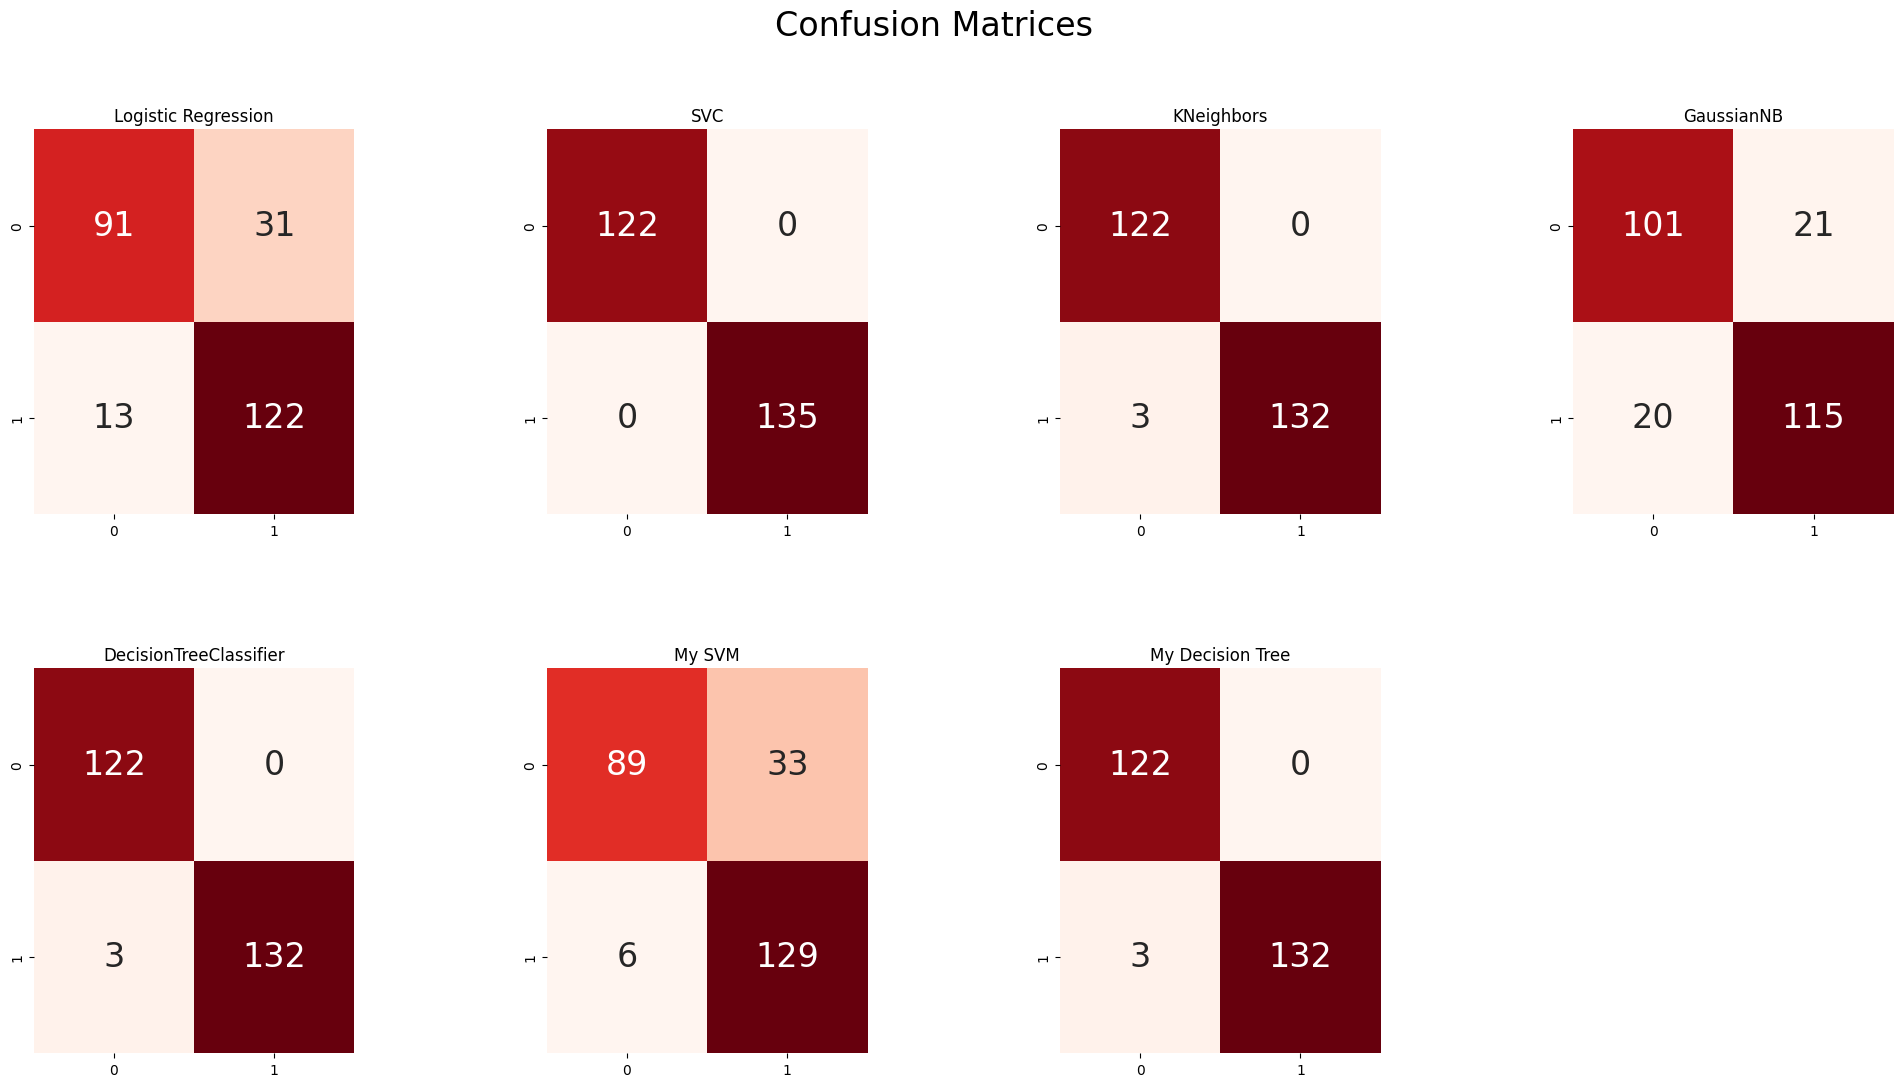

In [21]:
plt.figure(figsize=(24, 12))
plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)


for i, model_name in enumerate(trained_models):
    model = trained_models[model_name]
    cm = confusion_matrix(y_test, model.predict(x_test))
    plt.subplot(2, 4, i + 1)
    plt.title(model_name)
    sns.heatmap(cm,annot=True,cmap="Reds",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# Выводы


Лучшие результаты показали модели SVC, KNN и Decision Tree (собственная и библиотечная реализации).

Logistic Regression и собственная реализация SVM показали худший результат по сравнению с другими моделями.
